In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from matplotlib.markers import MarkerStyle
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# seen: train and val. unseen: test.
d = pd.read_csv('data.csv')
colnum = [7,9,10,11,14,15] #peakmag/duration/rise/fade/b/A_V
data_seen, data_test, class_seen, class_test = train_test_split(d[d.columns[colnum]], d['class'], train_size = 0.9, random_state = 12345)
data_train, data_val, class_train, class_val = train_test_split(data_seen, class_seen, train_size = 0.9, random_state = 12345)

In [4]:
#set up model
model = KNeighborsClassifier(n_neighbors = 20, weights = 'uniform', p = 2)
model.fit(data_train, class_train)

KNeighborsClassifier(n_neighbors=20)

In [5]:
#get number of correct classifications, probabilities
probabilities = model.predict_proba(data_val)
numcorrect = 0
for index,row in enumerate(probabilities):
    if row[1] >= 0.5 and class_val.to_numpy()[index] == 1:
        numcorrect += 1
    elif row[0] >= 0.5 and class_val.to_numpy()[index] == 0:
        numcorrect += 1
print(numcorrect)
print(numcorrect / len(probabilities))

414
0.9366515837104072


In [13]:
# calculate true/false positives/negatives, and keep track of incorrect classifications to do further analysis
predictions = model.predict(data_val)
tp, tn, fp, fn = 0, 0, 0, 0
incorrect = []
d = pd.read_csv('data.csv')
c = class_val.to_numpy()
for idx,p in enumerate(predictions):
    if p == 1 and c[idx] == 1:
        tp += 1
    elif p == 1 and c[idx] == 0:
        fp += 1
        incorrect.append(d.loc[data_val.index[idx]])
    elif p == 0 and c[idx] == 0:
        tn += 1
    elif p == 0 and c[idx] == 1:
        fn += 1
        incorrect.append(d.loc[data_val.index[idx]])
print(f'True positives: {tp}\nFalse positives: {fp}\nTrue negative: {tn}\nFalse negatives: {fn}')
print(f'Score: {model.score(data_val, class_val)}')
print(f'Precision: {tp/(tp+fp)}')
print(f'Recall: {tp/(tp+fn)}')
incorrectdf = pd.DataFrame(incorrect)

True positives: 355
False positives: 25
True negative: 58
False negatives: 4
Score: 0.9343891402714932
Precision: 0.9342105263157895
Recall: 0.9888579387186629


In [11]:
# calculate true/false positives/negatives
predictions = model.predict(data_test)
tp, tn, fp, fn = 0, 0, 0, 0
c = class_test.to_numpy()
for idx,p in enumerate(predictions):
    if p == 1 and c[idx] == 1:
        tp += 1
    elif p == 1 and c[idx] == 0:
        fp += 1
    elif p == 0 and c[idx] == 0:
        tn += 1
    elif p == 0 and c[idx] == 1:
        fn += 1
print(f'True positives: {tp}\nFalse positives: {fp}\nTrue negative: {tn}\nFalse negatives: {fn}')
print(f'Score: {model.score(data_test, class_test)}')
print(f'Precision: {tp/(tp+fp)}')
print(f'Recall: {tp/(tp+fn)}')

True positives: 399
False positives: 22
True negative: 63
False negatives: 7
Score: 0.9409368635437881
Precision: 0.9477434679334917
Recall: 0.9827586206896551


In [14]:
# ZTF IDs for incorrect classifications
incorrectdf.loc[:,'ZTFID']

4354    ZTF19aalzdfg
4485    ZTF19abhvryy
3318    ZTF21abrgbex
4059    ZTF18abjrdjs
4370    ZTF19aanneuv
1637    ZTF20aamttiw
3948    ZTF17aaaocpq
4740    ZTF20abjapox
4350    ZTF19aalfjvu
2165    ZTF20acbnwyb
4763    ZTF20abpwtmi
4250    ZTF18acrhfbk
4707    ZTF20aayukfo
3965    ZTF18aaeauzu
4709    ZTF20aazbbqo
4111    ZTF18absdddn
4051    ZTF18abfgtcf
4035    ZTF18aaylbyr
4382    ZTF19aaprdox
4344    ZTF19aakswwb
4145    ZTF18abujubn
4237    ZTF18acgusct
4114    ZTF18absgmhg
4084    ZTF18abmjija
1207    ZTF19acbzgog
4008    ZTF18aaqlblz
4192    ZTF18abzrsuh
4628    ZTF19acrwxfn
4046    ZTF18abcohew
Name: ZTFID, dtype: object

In [17]:
# Find best k value
df = pd.DataFrame(columns=['k','accuracy'])
for k in range(1,101):
    model.set_params(n_neighbors = k)
    model.fit(data_train, class_train)
    df.loc[k,'k'] = k
    df.loc[k,'accuracy'] = model.score(data_val,class_val)


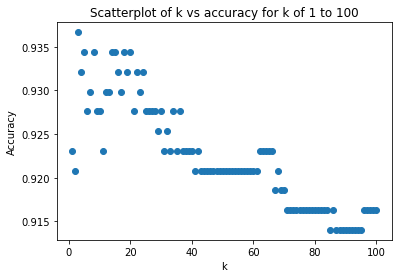

In [18]:
plt.scatter(df['k'], df['accuracy'])
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Scatterplot of k vs accuracy for k of 1 to 100')
plt.savefig('plots/k-accuracy.pdf')

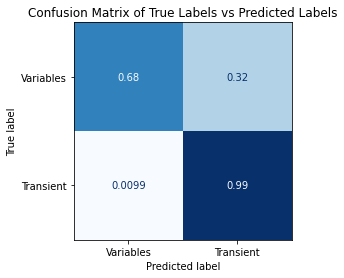

In [18]:
ConfusionMatrixDisplay.from_predictions(class_test, 
                                        model.predict(data_test), normalize='true', 
                                        display_labels=["Variables", "Transient"], 
                                        cmap=plt.cm.Blues, colorbar=False)
plt.title('Confusion Matrix of True Labels vs Predicted Labels')
plt.savefig('plots/confusion_matrix.pdf', bbox_inches='tight')